# CMC-15 - Lab 02 
## Aprendizado de máquina probabilístico

Importando pacotes:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Carregamos o `train_test_split` do SciKit Learn para facilitar a seleção de dados para treino e teste.

Carregando os dados:

In [2]:
df = pd.read_csv('republican_democrat.csv')
df.head()

,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,religious-groups-in-schools,anti-satellite-test-ban,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa,Target
0,n,y,n,y,y,n,n,y,?,y,y,y,n,y,republican
1,n,y,n,y,y,n,n,n,n,y,y,y,n,?,republican
2,?,y,y,?,y,n,n,n,y,n,y,y,n,n,democrat
3,n,y,y,n,y,n,n,n,y,n,y,n,n,y,democrat
4,y,y,y,n,y,n,n,n,y,?,y,y,y,y,democrat


Separando o output dos inputs:

In [3]:
X = df.drop(columns=['Target'])
Y = df['Target']

Separando treino e teste:

In [4]:
from typing import Tuple


xtrain: pd.DataFrame
xtest: pd.DataFrame
ytrain: pd.Series
ytest: pd.Series
(xtrain, xtest, ytrain, ytest) = train_test_split(X, Y, test_size=0.2)

Com a preparação de dados para a árvore feita, vamos criar os classificadores.

### 2.1 Classificador de árvore de decisão por ID3

Primeiramente vamos calcular a entropia:

In [5]:
from typing import List


def calculate_entropy(data: pd.DataFrame, label: str, label_values: List[str]) -> float:
    """
    :param data: DataFrame with data
    :param label: the name of the output label

    :return entropy: the entropy of the data
    """
    rows = data.shape[0]
    entropy = 0.0

    for val in label_values:
        rows_val = data[data[label] == val].shape[0]
        entropy_val = 0
        if rows_val != 0:
            frac = rows_val / rows
            entropy_val = - frac * np.log2(frac)
        entropy += entropy_val

    return entropy


In [6]:
# total entropy
calculate_entropy(df, 'Target', df['Target'].unique().tolist())

0.9585509783913739

Calculando o ganho de informação:

In [7]:
def calculate_info_gain(data: pd.DataFrame, label: str, feature_name: str, label_values: List[str]):
    feature_val_list: List[str] = data[feature_name].unique().tolist()
    rows = data.shape[0]
    feature_info = 0.0

    for val in feature_val_list:
        feature_value_data = data[data[feature_name] == val]
        feature_value_rows = feature_value_data.shape[0]
        feature_value_entropy = calculate_entropy(feature_value_data, label, label_values)
        prob = feature_value_rows / rows
        feature_info += prob * feature_value_entropy
    
    return calculate_entropy(data, label, label_values) - feature_info

In [8]:
# for 'handicapped-infants'
calculate_info_gain(df, 'Target', 'handicapped-infants', df['Target'].unique().tolist())

0.13714796724872425

Encontrando a *feature* com maior ganho:

In [9]:
def most_informative_feature(data: pd.DataFrame, label: str, label_values: List[str]):
    feature_list = data.columns.drop(label).to_list()
    max_info_gain = -1
    max_info_feature = None

    for feature in feature_list:
        feature_info_gain = calculate_info_gain(data, label, feature, label_values)
        if feature_info_gain > max_info_gain:
            max_info_gain = feature_info_gain
            max_info_feature = feature

    return max_info_feature

In [10]:
most_informative_feature(df, 'Target', df['Target'].unique().tolist())

'physician-fee-freeze'

Gerando uma sub-árvore:

In [11]:
def generate_sub_tree(data: pd.DataFrame, label: str, label_values: List[str], feature_name: str):
    feature_value_counts = data[feature_name].value_counts(sort=False)
    tree = {}

    for val, count in feature_value_counts.iteritems():
        feature_value_data = data[data[feature_name] == val]
        assigned_to_node = False
        for label_val in label_values:
            rows = feature_value_data[feature_value_data[label] == label_val].shape[0]
            if rows == count:
                tree[val] = label_val
                data = data[data[feature_name] != val]
                assigned_to_node = True
        if not assigned_to_node:
            tree[val] = "expand"

    return tree, data


Agora, o algoritmo ID3 é combinar os passos anteriores:

- encontrar a *feature* com maior ganho de informação
- fazer um nó da árvore com o nome da *feature* e os seus valores como galhos
  - se for uma classe pura, adicionar *as-is*
  - se não, adicionar um nó que será expandido posteriormente
- diminuir o dataset a partir das classes puras
- adicionar o nó com galhos para uma árvore
- expandir o galho da próxima classe impura com o dataset atualizado

Ao final, o dataset será esvaziado (não o original, somente uma cópia dele) e não haverá galhos a serem expandidos (sem `"?"`)

In [12]:
def make_tree(root: dict, prev_feature_value, data: pd.DataFrame, label: str, label_values: List[str]):
    if data.shape[0] != 0:
        max_info_feature = most_informative_feature(data, label, label_values)
        tree, new_data = generate_sub_tree(data, label, label_values, max_info_feature)
        next_root = None

        if prev_feature_value != None:
            root[prev_feature_value] = {}
            root[prev_feature_value][max_info_feature] = tree
            next_root: dict = root[prev_feature_value][max_info_feature]
        else:
            root[max_info_feature] = tree
            next_root: dict = root[max_info_feature]
        
        for node, branch in list(next_root.items()):
            if branch == "expand":
                feature_value_data = new_data[new_data[max_info_feature] == node]
                make_tree(next_root, node, feature_value_data, label, label_values)

In [13]:
def id3(data: pd.DataFrame, label: str):
    data_cpy = data.copy()
    tree = {}
    label_values: List[str] = data_cpy[label].unique().tolist()
    make_tree(tree, None, data_cpy, label, label_values)
    return tree

In [14]:
df_train = pd.concat([xtrain, ytrain], axis=1)
tree = id3(df_train, 'Target')

Visualizando a árvore como um objeto JSON (mais visível).

Pode ser que todas as linhas não apareçam no print, então salvamos para visualização onde for mais conveniente.

In [15]:
import json

tree_json = json.dumps(tree, indent=4)
print(tree_json)
with open("tree.json", "w") as file:
    json.dump(tree, file, indent=4)

{
    "physician-fee-freeze": {
        "y": {
            "synfuels-corporation-cutback": {
                "n": {
                    "duty-free-exports": {
                        "n": "republican",
                        "?": "republican",
                        "y": {
                            "immigration": {
                                "y": "republican",
                                "n": {
                                    "export-administration-act-south-africa": {
                                        "n": "republican",
                                        "?": {
                                            "water-project-cost-sharing": {
                                                "y": "republican",
                                                "n": "democrat"
                                            }
                                        },
                                        "y": "democrat"
                                    }
             

Para a predição, precisa-se caminhar recursivamente na árvore:

In [16]:
from typing import Any, Union


def predict(row: pd.Series, tree: Union[dict, Any]):
    if not isinstance(tree, dict):
        return tree
    else:
        root_node = next(iter(tree))
        feature_value = row[root_node]
        if feature_value in tree[root_node]:
            return predict(row, tree[root_node][feature_value])
        else:
            return None


Um pequeno teste:

In [17]:
predict(xtest.iloc[10], tree)

'republican'

In [18]:
predict(xtest.iloc[10], tree) == ytest.iloc[10]

True

Avaliando o modelo:

In [19]:
from typing import Callable


def evaluate(xtest: pd.DataFrame, ytest: pd.Series, predict_func: Callable, *args, **kwargs):
    correct = 0
    wrong = 0
    results = []
    for idx, _ in xtest.iterrows():
        result = predict_func(xtest.loc[idx], *args, **kwargs)
        results.append(result)
        if result == ytest.loc[idx]:
            correct += 1
        else:
            wrong += 1
    accuracy = correct / (correct + wrong)
    return accuracy, pd.Series(results, index=ytest.index)

In [20]:
accuracy_tree, results_tree = evaluate(xtest, ytest, predict, tree=tree)
accuracy_tree

0.9518072289156626

### 2.2 Classificador a priori (moda dos valores de saída)

Esse classificador é bem simples, ele só retorna a moda dos valores de treinamento:

In [21]:
from typing import Callable


def create_apriori(data: pd.Series) -> Callable:
    return lambda: data.mode().iloc[0]

In [22]:
apriori = create_apriori(ytrain)

apriori()

'democrat'

Avaliando:

In [23]:
predict_apriori = lambda _: apriori()
accuracy_apriori, results_apriori = evaluate(xtest, ytest, predict_apriori)
accuracy_apriori

0.6506024096385542

### 2.3 Comparação

Utilizando o pacote `sklearn` para não necessitar da implementação das métricas do zero

In [24]:
import sklearn.metrics as metrics

**Nota: se der erro por NoneType, provavelmente houve uma divisão dos dados infeliz da função `train_test_split` que afetou o modelo. Rodar o notebook de novo pode ser necessário**

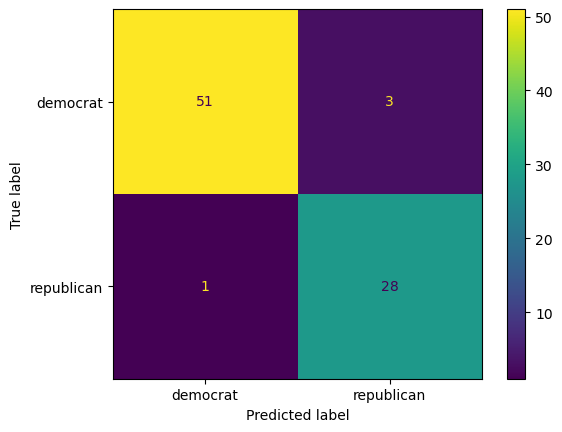

In [25]:
cm_tree = metrics.ConfusionMatrixDisplay.from_predictions(ytest, results_tree)
cm_tree.figure_.savefig('CM_Tree.png')

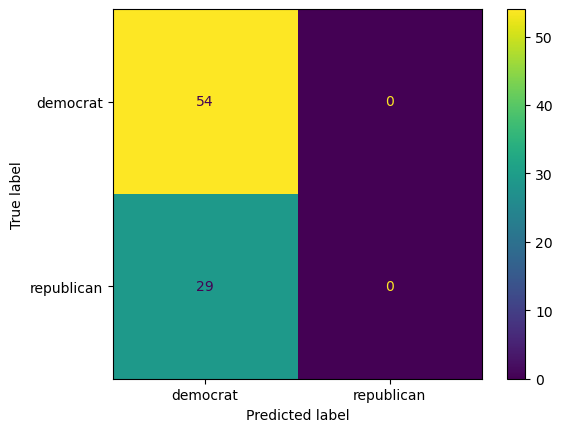

In [26]:
cm_apriori = metrics.ConfusionMatrixDisplay.from_predictions(ytest, results_apriori)
cm_apriori.figure_.savefig('CM_Apriori.png')

Como é um problema de classificação, MSE não é recomendado.

Para a estatística Kappa:

In [27]:
metrics.cohen_kappa_score(ytest, results_tree)

0.8956631049654306

In [28]:
metrics.cohen_kappa_score(ytest, results_apriori)

0.0

Como esperado, o classificador *a priori* teve métricas piores, sendo a árvore de decisão melhor. Uma maneira de melhorar o classificador seria implementar uma estratégia bayesiana, a mais simples sendo o *naive Bayes*.